#### **WHITE WINE ML PIPELINE**

In [1]:
# Import all the necessary libraries
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib


In [4]:
# Load the dataset
path = r"C:\Users\kanyi\Desktop\practice_ml_fast_api\white_wine\winequality-white.csv"

df = pd.read_csv(path, sep=";")

In [5]:
# display the data
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
# Check the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [ ]:
# Print the columns in the dataset
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [8]:
# Check the unique values of the target column
df['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

1. Data Overview
- The dataset uses 4898 white wine samples
- Each wine has 11 measurements that describes the chemical properties of the features, and a quality score between 3 and 8
- The goal is to understand what makes a wine 'good' or 'bad'. and prepare the data for ML model that predicts the quality of the wine

In [10]:
# Check the desciptive summary of the dataset
df.describe().T.style.background_gradient(axis=0)

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.000000,6.854788,0.843868,3.800000,6.300000,6.800000,7.300000,14.200000
volatile acidity,4898.000000,0.278241,0.100795,0.080000,0.210000,0.260000,0.320000,1.100000
citric acid,4898.000000,0.334192,0.121020,0.000000,0.270000,0.320000,0.390000,1.660000
residual sugar,4898.000000,6.391415,5.072058,0.600000,1.700000,5.200000,9.900000,65.800000
chlorides,4898.000000,0.045772,0.021848,0.009000,0.036000,0.043000,0.050000,0.346000
free sulfur dioxide,4898.000000,35.308085,17.007137,2.000000,23.000000,34.000000,46.000000,289.000000
total sulfur dioxide,4898.000000,138.360657,42.498065,9.000000,108.000000,134.000000,167.000000,440.000000
density,4898.000000,0.994027,0.002991,0.987110,0.991723,0.993740,0.996100,1.038980
pH,4898.000000,3.188267,0.151001,2.720000,3.090000,3.180000,3.280000,3.820000
sulphates,4898.000000,0.489847,0.114126,0.220000,0.410000,0.470000,0.550000,1.080000


2. What does our data tell us

Features
- The acidity, alcohol, PH they may or may not affect the quality of the wine. The std is low which means the there is low disparity between the datapoint.
- The sulfur oxides may affect the quality of the wine, as they have very high variablity.
- The features are not in the same range, hence scalig is highly recommended.

Target
- Most of the quality scores falls between 5 and 6 (Average).
- Only a few wine scored very low (3-4) or very high (7-9)

In [13]:
# Check the shape of the data
df.shape

(4898, 12)

In [12]:
# Check the duplicates
df.duplicated().sum()

np.int64(937)

In [15]:
# Handle duplicate 
df.drop_duplicates(inplace=True)

In [16]:
# reconfirm duplicate have been handled
df.duplicated().sum()

np.int64(0)

In [17]:
# Check for missing values
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [19]:
# Reclassify the target variable
df = df.replace({"quality":{9:'Best', 8:'Best', 7:'Good', 6:'Good', 5:'Average', 4:'Bad', 3:'Bad'}})

In [20]:
# Check the reclassification col
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,Good
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,Good
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,Good
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,Good
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,Good


3. Getting the data ready
- No missing values or invalid values.
- 937 duplicated values were found and were handled by dropping.
- All columns were numerical (no need for encoding)
- The target variable was reclassified 
- The features shows they are not in the same range, recommend standadizing them using MinMaxscaler to put them all in the same scale(0,1), in order for the model to learn fairly from each one.
- We will split the data into features and target, also train and test sets.
- After this, the data will be ready to train ML algorithm.

In [21]:
# Split the data into features and target
y = df['quality']
X = df.drop('quality', axis=1)

In [22]:
# display X
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6


In [23]:
# display y
y.head()

0    Good
1    Good
2    Good
3    Good
6    Good
Name: quality, dtype: object

In [26]:
# Scale the data using MinMaxscaler
scaler = MinMaxScaler(feature_range=(0,1))

X_scaled = scaler.fit_transform(X)

In [ ]:
# Split into train and test sets using the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [30]:
# Let's create a dictionary that stores the model
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "KNeighbors": KNeighborsClassifier(),
    "Naive_Bayes": GaussianNB()
}

Training LogisticRegression
LogisticRegression Accuracy - 0.6658259773013872


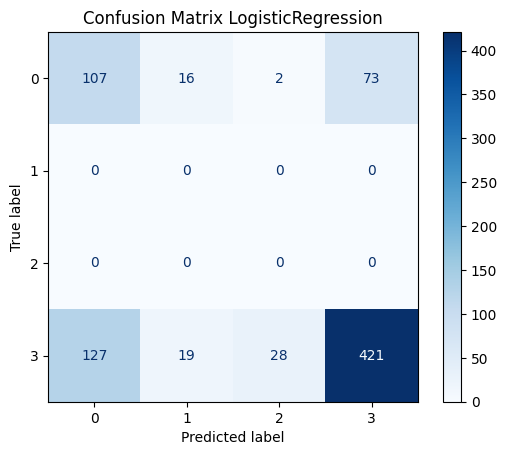

Training RandomForest
RandomForest Accuracy - 0.6897856242118537


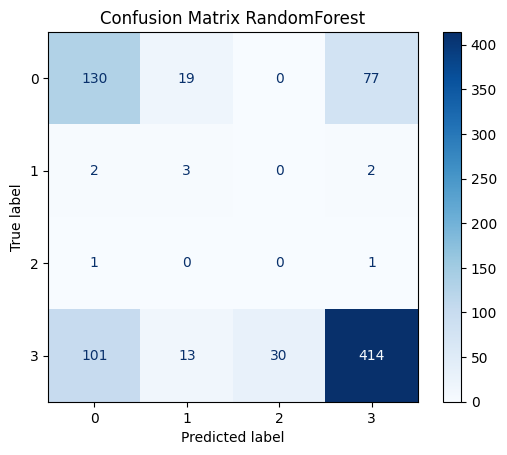

Training DecisionTree
DecisionTree Accuracy - 0.5598991172761665


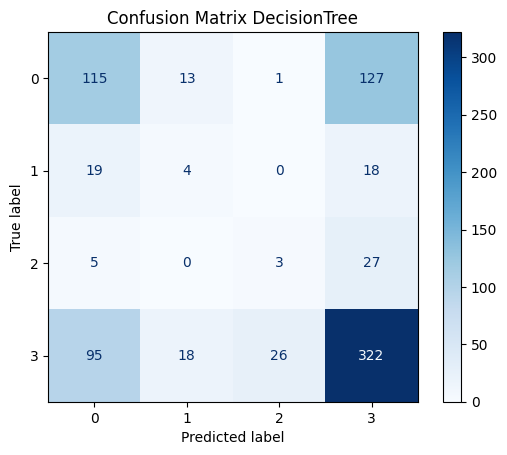

Training KNeighbors
KNeighbors Accuracy - 0.6796973518284993


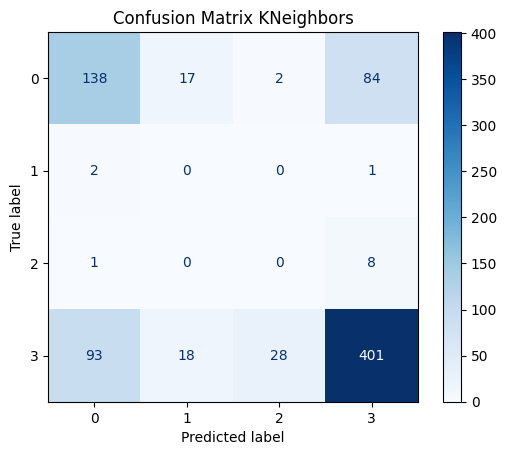

Training Naive_Bayes
Naive_Bayes Accuracy - 0.5737704918032787


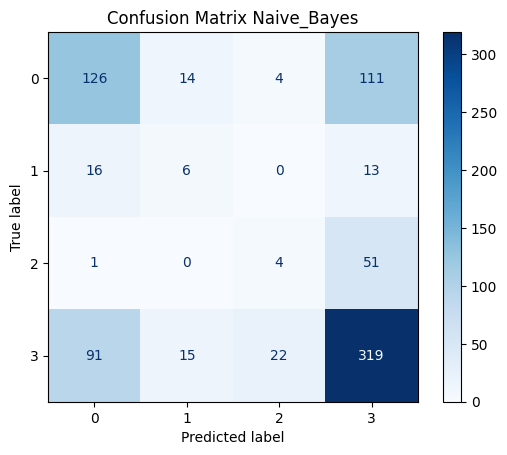

In [36]:
# Initiate the model
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    results[model] = accuracy
    print(f"{model_name} Accuracy - {accuracy}")

    # Let's include a confusion matrix
    cm = confusion_matrix(y_pred, y_test)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Let's plot with model name as title
    display.plot(cmap='Blues')
    plt.title(f"Confusion Matrix {model_name}")
    plt.show()


4. Training our model
- Created a dictionary to store the models
- We fed the data to the model to learn and use that for prediction
- We checked the accuracy to evaluate the model to see how well it is predicting
- Based on the accuracy result and the ratio of True Predicted to False predicted; RandomForest perfomed best
- We recommend hyperparameter tuning to improve the model performance



In [37]:
# Let's get the parameter for RandomForest
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Let's tune RandomForest - set out parameters
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2,5,10],
    'bootstrap': [True, False]
}

# Let's define RandomSearch 
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_grid, cv=5, n_jobs=-1, verbose=1)
random_search.fit(X_train,y_train)
print(f"Best parameter for Random Forest {random_search.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameter for Random Forest {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}


In [41]:
# Cross validation for the best Model
best_model = random_search.best_estimator_
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5)

print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean Cross Validation Scores: {cv_scores.mean()}")

Cross Validation Scores: [0.65447667 0.6780303  0.69318182 0.68560606 0.70833333]
Mean Cross Validation Scores: 0.6839256372043258


6. Hyperparameter result
- Set the parameter using a list to save computational time
- RandomSearch method was selected to as it is computationally cheap, and it also selects random parameters.
- The model that perfomed best have these parameters - {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
- Cross Validation was used to check how well the model will predict unseen or new sets of data.
- The average of the cross validation is 0.68% (estimation of the model will predict)

In [42]:
# Classification report
y_pred_rf = best_model.predict(X_test)
print("Classification Report")
print(classification_report(y_test,y_pred_rf, zero_division=1))

Classification Report
              precision    recall  f1-score   support

     Average       0.58      0.54      0.56       234
         Bad       0.50      0.09      0.15        35
        Best       1.00      0.00      0.00        30
        Good       0.74      0.86      0.79       494

    accuracy                           0.70       793
   macro avg       0.71      0.37      0.38       793
weighted avg       0.69      0.70      0.67       793



Summary 
- The model overall accuracy is 70%, out of 4 samples 3 will be correctly predicted.
- The 'Good'-quality wines is the most common: the model did well, caught most of them correctly (recall=0.86%), and was fairly accurate with its prediction (precision=0.74%)
- The 'Average'-quality wines come: the model did okay, caught some of them correctly (recall=0.54%), and with its prediction (precision=0.58%) 
- Best and bad-quality wines: the clasese of the samples were few; the model could not learn their patterns properly, could barely recognised any of them (0.00/0.09)
- Save our best model and scaler for reusability

In [45]:
# Let's save our best model
model = joblib.dump(best_model, 'best_model.pkl')

# let's save our scaler
scaler = joblib.dump(scaler, 'scaler.pkl')